# M3GNetとASEを用いた分子シミュレーション
## #1 LLZにおけるLiイオン拡散のMDシミュレーション
<BR>

参考文献（M3GNet）<BR>
- GITHUB https://github.com/materialsvirtuallab/m3gnet
- Chen, C., Ong, S.P. A universal graph deep learning interatomic potential for the periodic table. Nat Comput Sci 2, 718–728 (2022). https://doi.org/10.1038/s43588-022-00349-3. (論文引用先)

  
作成：中山将伸 (2023.11.1)  

## 【必須】ASEモジュール他のインポート


In [1]:
import numpy as np
import math, random

import os,sys,csv,glob,shutil,re,time
from time import perf_counter
from joblib import Parallel, delayed
args = sys.argv

# sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import ase #
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, UnitCellFilter
from ase.optimize import LBFGS
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import Atoms
from ase.io import read, write
from ase.io import Trajectory
from ase import units
from ase.build import bulk, make_supercell
from ase.visualize import view




## 【必須】Atoms object 入力

In [2]:
#POSCAR ファイルの読み込み

inpf="./inputs/Li7La3Zr2O12.cif"
atomsprim=read(inpf)
atoms=atomsprim.copy()
print ("number of atoms:",len(atoms.positions))
print ("composition:", atoms.symbols)
print ("cell parameters:", atoms.get_cell_lengths_and_angles())
#view(atomsprim, viewer="ngl")
view(atomsprim, viewer="x3d")
#view(atomsprim)

number of atoms: 192
composition: Li56La24Zr16O96
cell parameters: [13.23607  13.23607  12.701706 90.       90.       90.      ]


/var/folders/0f/gst3ndcj1gl6tx25nxpl4vh80000gn/T/ipykernel_76386/362561947.py:8: DeprecationWarning: Please use atoms.cell.cellpar() instead
  print ("cell parameters:", atoms.get_cell_lengths_and_angles())


In [3]:
atoms.positions

array([[ 6.618035  ,  0.        ,  9.5262795 ],
       [ 6.618035  ,  0.        ,  3.1754265 ],
       [ 6.618035  ,  6.618035  ,  6.350853  ],
       [ 0.        ,  0.        ,  6.350853  ],
       [ 9.01655648,  2.39852148,  0.        ],
       [ 4.21951352,  2.39852148,  6.350853  ],
       [ 2.39852148,  2.39852148,  3.1754265 ],
       [10.83754852,  2.39852148,  9.5262795 ],
       [ 4.21951352,  4.21951352,  9.5262795 ],
       [ 9.01655648,  4.21951352,  3.1754265 ],
       [10.83754852,  4.21951352,  6.350853  ],
       [ 9.01655648, 10.83754852,  6.350853  ],
       [ 4.46763027,  1.06570879,  4.05366691],
       [ 8.76843973,  1.06570879, 10.40451991],
       [ 1.06570879, 11.08566527,  7.22909341],
       [ 5.55232621,  4.46763027,  7.22909341],
       [ 8.76843973,  5.55232621,  5.47261259],
       [11.08566527, 12.17036121,  5.47261259],
       [ 5.55232621,  2.15040473,  8.64803909],
       [ 7.68374379,  2.15040473,  2.29718609],
       [11.08566527,  5.55232621,  4.053

## （選択）超構造の作成

In [11]:
#=============入力====================================================
atoms = make_supercell(atomsprim, [[2, 0, 0],[0, 2, 0],[0,0,2]])
#=============入力====================================================
print ("number of atoms:",len(atoms.positions))
print ("composition:", atoms.get_chemical_formula(mode="hill"))
print ("cell parameters:", atoms.get_cell_lengths_and_angles())
view(atoms, viewer="ngl")

number of atoms: 1536
composition: La192Li448O768Zr128
cell parameters: [26.47214  26.47214  25.403412 90.       90.       90.      ]


/var/folders/0f/gst3ndcj1gl6tx25nxpl4vh80000gn/T/ipykernel_76386/1695408637.py:6: DeprecationWarning: Please use atoms.cell.cellpar() instead
  print ("cell parameters:", atoms.get_cell_lengths_and_angles())


AttributeError: 'super' object has no attribute '_ipython_display_'

In [18]:
atoms = atomsprim #計算を軽くするためにサイズを単位講師のみに落とす
atoms

Atoms(symbols='La24Li56O96Zr16', pbc=True, cell=[13.23607, 13.23607, 12.701706], spacegroup_kinds=..., calculator=M3GNetCalculator(...))

## 【必須】Atoms objectにM3GNetのポテンシャルを導入

In [27]:
#from m3gnet.models import M3GNet, M3GNetCalculator, Potential
#potential = Potential(M3GNet.load()) #M3GNetのデフォルトポテンシャルを導入　（自分で作ったポテンシャルは要別途指定）
#calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# This is code for mgl
import matgl
from matgl.ext.ase import M3GNetCalculator
potential = matgl.load_model("M3GNet-MP-2021.2.8-PES")
calculator = matgl.ext.ase.M3GNetCalculator(potential=potential, stress_weight=0.01)


atoms.calc=calculator
# ASE versionが古い場合は以下を使う
#atoms.set_constraint()
#atoms.set_calculator(calculator)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

## （選択）M3GNet 構造緩和なしの計算

In [21]:
#static 計算
print ("number of ions:",len(atoms))

s_time = perf_counter()
energy=atoms.get_potential_energy()
force=atoms.get_forces()
e_time = perf_counter()

elapsedt=e_time-s_time
print ("computation time",elapsedt, "sec")

print ("energy:",energy)
maxf = np.sqrt(((force**2).sum(axis=1).max()))
print ("max force",maxf)



number of ions: 192
computation time 0.0006631249561905861 sec
energy: -1368.886962890625
max force 0.06498988


In [17]:
force

array([[ 8.7696244e-06,  1.8066552e-05,  6.4895139e-06],
       [ 1.3181125e-06,  6.1626779e-06, -5.1879615e-06],
       [ 5.1080715e-06, -2.8889626e-06,  4.7010835e-06],
       ...,
       [-2.8582111e-02, -7.9780817e-04, -2.7195156e-02],
       [ 8.0138445e-04, -2.8573558e-02, -2.7195023e-02],
       [-8.0898404e-04, -2.8578922e-02, -2.7191807e-02]], dtype=float32)

## (選択)M3GNet 構造緩和計算

各種アルゴリズムがある(FIRE, LBFGSなど　下記の例はLBFGSを使用)<BR>
得られたエネルギー値から電位などを計算することもできる。<BR>
NVT-MDを行う前に一度構造緩和計算をすることを推奨（格子定数を適切な値にするため）<BR>

In [26]:
#relax 計算
from ase.optimize import LBFGS, BFGS, FIRE #<- 基本的にLBFGS, FIREを使うらしい
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, UnitCellFilter, ExpCellFilter

ucf=ExpCellFilter(atoms)
opt = LBFGS(ucf, trajectory="relax.traj",logfile="log.relax")
opt.run(steps=2000) #本当は数千ステップ

#この時点でatomsのデータが書き換わっている

energy=atoms.get_potential_energy()
force=atoms.get_forces()

print ("energy:",energy)
print ("cell parameters:", atoms.get_cell_lengths_and_angles())
maxf = np.sqrt(((force**2).sum(axis=1).max()))
print ("max force",maxf)

#ase.io.write("CONTCAR", atoms, format="vasp")
ase.io.write("relax.cif", atoms, format="cif")

#view(atoms, viewer="ngl")


energy: -1368.995849609375
cell parameters: [13.26445824 13.26407443 12.65107985 90.00014732 89.99988875 89.99974268]
max force 0.003949565


/var/folders/0f/gst3ndcj1gl6tx25nxpl4vh80000gn/T/ipykernel_76386/2613136428.py:5: FutureWarning: Import ExpCellFilter from ase.filters
  ucf=ExpCellFilter(atoms)
/var/folders/0f/gst3ndcj1gl6tx25nxpl4vh80000gn/T/ipykernel_76386/2613136428.py:15: DeprecationWarning: Please use atoms.cell.cellpar() instead
  print ("cell parameters:", atoms.get_cell_lengths_and_angles())


In [42]:
view(atoms, viewer="x3d")

## (選択)M3GNet MD計算




### パラメーター入力と計算の実行

下記の例ではNVT-MD計算を実行している<BR>
データの出力は "MD.traj"と"MD.log"<BR>

In [29]:
atoms

Atoms(symbols='La24Li56O96Zr16', pbc=True, cell=[[13.264458240789514, 2.978510897703295e-05, 1.2837629659230843e-05], [2.978510897703295e-05, 13.264074426458176, -1.7000389375658672e-05], [1.231935141387538e-05, -1.631405301845923e-05, 12.651079850181365]], momenta=..., spacegroup_kinds=..., calculator=M3GNetCalculator(...))

In [32]:
# NVT-MD計算
# =====================　パラメーター入力 ==================
t_step=1         #１ステップ当たりのシミュレーション時間（単位 1fs)←デフォルトの単位, この時間は直線で運動
mdstep=200    #全計算ステップ ← 本当であれば100psぐらい、すなわち数10万ステップぐらい必要かな？
mdtemp=1773       #単位 K　← リチウムイオンは本来であれば300Kを想定しているが短い時間では十分な統計が取れないので温度を上げているとのこと, 時間を長くすれば温度を下げても十分な統計が取れる
loginterval=1    #データの出力間隔（ステップ数で指定）

#mdstep=10000 (10ps) で実績 1912 sec
# 100ps程度は最低限必要
# =====================　パラメーター入力 ==================

atoms.calc = calculator
MaxwellBoltzmannDistribution(atoms, temperature_K=mdtemp)  #初期値を与える ← マックスウェル分布（統計的な初期速度分布を与える）

dyn = Langevin(
            atoms,
            t_step * units.fs, #ps単位にしたいのであれば units.ps
            temperature_K=mdtemp,
            friction=0.02,
            trajectory="MD.traj",
            loginterval=loginterval,
            append_trajectory=False, #前行った計算に追加するか否か
        )

dyn.attach(MDLogger(dyn, atoms, logfile="MD.log", header=True, stress=False,
                            peratom=True, mode="w"), interval=loginterval)

s_time = perf_counter()
dyn.run(mdstep)
proctime = perf_counter() - s_time

print ("process time = {:>10d} sec".format(int(proctime)))



process time =        103 sec


In [33]:
trj = read("MD.traj", index=":-1:1") # index＝は　開始ステップ、終了ステップ、ステップ間隔に対応  1:20:1 で、第１ステップから第２０ステップまで１ステップ間隔で読み取り　数値記載を省略するとデフォルト(1:-1:1)
#trj = read("MD.traj", index="10:200:1") #他にもOVITO とかもあるらしい
print (len(trj))
#view(trj, viewer="ngl")
view(trj)


200


<Popen: returncode: None args: ['/usr/local/bin/python3', '-m', 'ase', 'gui'...>

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on clos

### NVT-MD計算結果の評価：MSD計算

In [35]:
trj = read("inputs/MD_LLZ50ps.traj", index=":-1:1")  #このパスは計算済みのファイル #他の優れた読み込み方もあるらしい
print (len(trj))


50000


In [36]:
view(trj)


<Popen: returncode: None args: ['/usr/local/bin/python3', '-m', 'ase', 'gui'...>

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/pyplot.py", line 614, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on clos

In [37]:
#解析パラメーター入力

targetatom="Li"
fileout="msd.csv"
headerskip=200 #初め200データを捨てる
footerskip=1000 #最後1000データを捨てる
dim=3

#--------------------------------
Navg=100  #変更不要Mg
logitvl=10 #loginterval  #変更不要
potim=1 #t_step  #変更不要

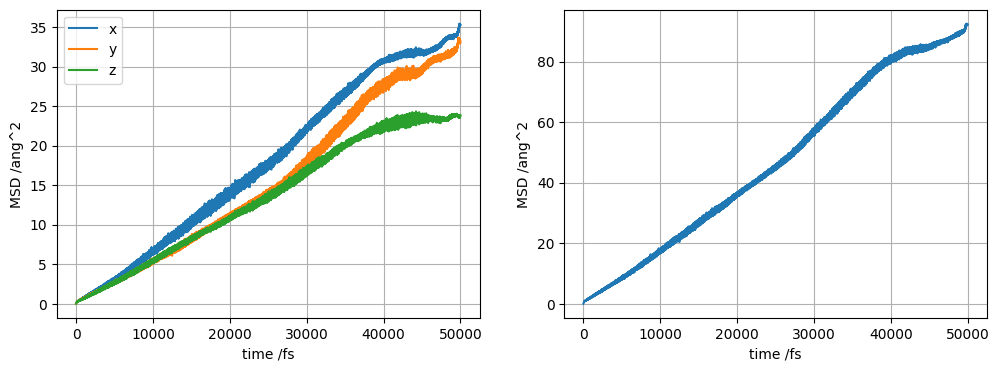

In [38]:
D_index = [i for i, x in enumerate(trj[0].get_chemical_symbols()) if x == targetatom]


positions_x = []
positions_y = []
positions_z = []
msd_xp=[]
msd_yp=[]
msd_zp=[]
msd_allp = []

for i in range(len(trj)):
               positions_x.append(trj[i].get_positions()[D_index,0])
               positions_y.append(trj[i].get_positions()[D_index,1])
               positions_z.append(trj[i].get_positions()[D_index,2])

for i in range(len(trj)):
    msd_xt=0
    msd_yt=0
    msd_zt=0
    msd_allt=0
    
    for j in range(Navg):
        rn=np.random.randint(len(trj)-i)
        #print (rn,i)
        msd_xt = msd_xt + (positions_x[i+rn]-positions_x[rn])**2
        msd_yt = msd_yt + (positions_y[i+rn]-positions_y[rn])**2
        msd_zt = msd_zt + (positions_z[i+rn]-positions_z[rn])**2
        msd_allt = msd_allt + np.sum((trj[i+rn].get_positions()[D_index]-trj[rn].get_positions()[D_index])**2)
    msd_xp.append(msd_xt/Navg)
    msd_yp.append(msd_yt/Navg)
    msd_zp.append(msd_zt/Navg)
    msd_allp.append(msd_allt/Navg)

msd_x=np.mean(msd_xp,axis=1)
msd_y=np.mean(msd_yp,axis=1)
msd_z=np.mean(msd_zp,axis=1)
msd=np.array(msd_allp)/len(D_index)

step=np.array(range(len(trj)))*potim/logitvl
savemsd=np.concatenate([step.reshape(-1,1),msd.reshape(-1,1),msd_x.reshape(-1,1),msd_y.reshape(-1,1),msd_z.reshape(-1,1)],axis=1)
np.savetxt(fileout, savemsd, header="step, msd(ang^2), msd_x(ang^2), msd_y(ang^2), msd_z(ang^2)",delimiter=',')

# MSDグラフ描画

fig = plt.figure(figsize=(12,4), facecolor='w')

ax1 = fig.add_subplot(1,2,1)
ax1.plot(range(len(msd_x)), msd_x, label="x")
ax1.plot(range(len(msd_y)), msd_y, label="y")
ax1.plot(range(len(msd_z)), msd_z, label="z")
ax1.legend()
ax1.set_xlabel("time /fs")
ax1.set_ylabel("MSD /ang^2")
ax1.grid(True)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(range(len(msd)), msd, label="all")
ax2.set_xlabel("time /fs")
ax2.set_ylabel("MSD /ang^2")
ax2.grid(True)

#plt.xlim(0,100)
#plt.ylim(0,10)

In [39]:
from scipy import stats
slope, intercept, r_value, _, _ = stats.linregress(savemsd[headerskip:len(trj)-footerskip,0],savemsd[headerskip:len(trj)-footerskip,1])
print("slope:",slope, "intercept:",intercept, "R^2:",r_value**2)
D_all=slope*1e-16/1e-15/2/dim

slope, intercept, r_value, _, _ = stats.linregress(savemsd[headerskip:len(trj)-footerskip,0],savemsd[headerskip:len(trj)-footerskip,2])
print("slope:",slope, "intercept:",intercept, "R^2:",r_value**2)
D_x=slope*1e-16/1e-15/2/dim

slope, intercept, r_value, _, _ = stats.linregress(savemsd[headerskip:len(trj)-footerskip,0],savemsd[headerskip:len(trj)-footerskip,3])
print("slope:",slope, "intercept:",intercept, "R^2:",r_value**2)
D_y=slope*1e-16/1e-15/2/dim

slope, intercept, r_value, _, _ = stats.linregress(savemsd[headerskip:len(trj)-footerskip,0],savemsd[headerskip:len(trj)-footerskip,4])
print("slope:",slope, "intercept:",intercept, "R^2:",r_value**2)
D_z=slope*1e-16/1e-15/2/dim
print ("---------------------------------------")
print ("D(all)=",D_all, "cm^2/sec")
print ("D(x)=",D_x, "cm^2/sec")
print ("D(y)=",D_y, "cm^2/sec")
print ("D(z)=",D_z, "cm^2/sec")


slope: 0.019705610241909585 intercept: -1.996569914976675 R^2: 0.993846569191505
slope: 0.007453083846778277 intercept: -0.5632694023015254 R^2: 0.9932031090928926
slope: 0.006931568165909177 intercept: -1.7147402817887425 R^2: 0.9882173511383384
slope: 0.005320958229222116 intercept: 0.28143976911362323 R^2: 0.9893749158475639
---------------------------------------
D(all)= 0.00032842683736515973 cm^2/sec
D(x)= 0.00012421806411297128 cm^2/sec
D(y)= 0.00011552613609848627 cm^2/sec
D(z)= 8.868263715370191e-05 cm^2/sec


### NVT-MD計算結果の評価：Population density の出力

以下、計算対象に合わせて入力が必要
出力ファイルは output.rho → VESTAによる読み込み可能。


In [40]:

# トラジェクトリファイルを読み込み(あらかじめ用意してあるファイル)
#trj = read('MD_LLZ50ps.traj', index=':')  # すべてのフレームを読み込む  #ファイル名は要修正
tgtion="Li"

# ボクセルのサイズ定義
meshx = 50
meshy = 50
meshz = 50
rho = np.zeros((meshx, meshy, meshz))


In [41]:

# 各フレームの原子の分率座標を読み取り、ボクセルに分配
for atoms in trj:
    # 分率座標を取得

    ion_mask = [atom.symbol == 'Li' for atom in atoms]
    tgt_atoms = atoms[ion_mask]
    fractional_positions = tgt_atoms.get_scaled_positions()
    
    # 各原子の分率座標を適切なボクセルにカウント
    for pos in fractional_positions:
        # 分率座標をボクセルインデックスに変換
        index = np.floor(pos * [meshx, meshy, meshz]).astype(int)

        # エッジケース: 分率座標がちょうど1.0の場合、インデックスがmeshサイズになる場合があるため、最大値をmeshサイズ-1に制限
        index = np.clip(index, 0, np.array([meshx, meshy, meshz]) - 1)

        # カウントアップ
        rho[tuple(index)] += 1

# rho を度数から確率に変換する場合（オプション）
total_counts = np.sum(rho)
if total_counts > 0:
    rho /= total_counts

# rhoをファイルに保存（オプショナル）
np.save('density_distribution.npy', rho)

stockdens=np.array([])
stockdens2=np.array([])

loop=loopre=0

for i in range(meshx):
    for j in range(meshy):
        for k in range(meshz):
            stockdens=np.append(stockdens,float(rho[i,j,k]))

loop=int(len(stockdens)/5)
loopre=len(stockdens)%5

with open('output.rho','w',encoding='utf-8',) as f:
    
    msg="cell\n {0:3.5f} {1:3.5f} {2:3.5f}\n {3:3.5f} {4:3.5f} {5:3.5f}\n".format(*trj[0].cell.cellpar())
    f.write(msg)
    msg="{0:5d} {1:5d} {2:5d}  ".format(meshx,meshy,meshz)
    f.write(msg)
    lat_a=trj[0].cell.cellpar()[0]/0.52918
    lat_b=trj[0].cell.cellpar()[1]/0.52918
    lat_c=trj[0].cell.cellpar()[2]/0.52918
    msg="{0:3.5f} {1:3.5f} {2:3.5f}\n".format(lat_a,lat_b,lat_c)
    f.write(msg)

    for i in range(loop):
        for j in range(5):
            msg="{0:1.8e} ".format(stockdens[i*5+j])
            f.write(msg)
        f.write("\n")

    for k in range(loopre):
        msg="{0:1.8e} ".format(stockdens[i*(loop+1)+k])
        f.write(msg)
        #print (stockdens[i*(loop+1)+k])
    f.write("\n")
